In [12]:
import glob
import re

import numpy as np
import pandas as pd
import tqdm
import itertools
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
# pd.options.display.max_columns = 2000

/tmp/ipykernel_47728/2048820180.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [13]:
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe

# create fake dataframes
df1 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"],
                   columns=["I", "J", "K", "L", "M"])
df2 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"],
                   columns=["I", "J", "K", "L", "M"])
df3 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"], 
                   columns=["I", "J", "K", "L", "M"])

# display(df1)

# # Then, just call :
# plot_clustered_stacked([df1, df2, df3],["df1", "df2", "df3"])
    

In [14]:
def convert_times_2_timedelta(time_s):
    time_s = time_s.strip()
    if not time_s.endswith("s"):
        return float(time_s)
    else:
        return pd.Timedelta(time_s) / np.timedelta64(1, "us")

def remove_emptystr_in_list(l):
    return list(filter(lambda x: x.strip() != "", l))


def strip_each_in_list(l):
    return [each.strip() for each in l]


class IteratorLogs():

    def __init__(self, logfile) -> None:
        with open(logfile) as f:
            self.lines = f.readlines()
        self.index = 0

    def next(self):
        temp = self.next_line()
        # filter GLOG
        while temp.find('.h:') != -1 or temp.find('.cc:') != -1:
            temp = self.next_line()
        # print(self.index, temp)
        return temp

    def next_line(self):
        if self.index == len(self.lines):
            raise StopIteration()
        temp = self.lines[self.index]
        self.index += 1
        return temp


# run_log_file to [{ts: ts1, k1: v, k2: v}, (ts2, {})]
def parse_log(logfile, ):
    iter_log = IteratorLogs(logfile)

    dic = defaultdict(lambda: [])

    proc_num = -1
    perf_counter_names = set()
    
    import re
    
    while True:
        try:
            each_line = iter_log.next()
            each_line = each_line.strip()
            r = re.search(r'\[proc (\d)\] (\d+) steps, (total:.*$)', each_line)
            if r:
                proc = int(r[1])
                proc_num = max(proc_num,  proc)
                step = int(r[2])
                items = r[3].split(", ")
                items = [(each.split(": ")[0], each.split(": ")[1]) for each in items]
                for each_k, each_v in items:
                    dic[f'proc{proc}_{each_k}'] = [float(each_v)]
                    perf_counter_names.add(each_k)
                continue

            r = re.search(r'Step(\d+):rank(\d), (time: .*$)', each_line)
            if r:
                proc = int(r[2])
                proc_num = max(proc_num,  proc)
                step = int(r[1])
                items = r[3].split(", ")
                items = [(each.split(": ")[0], each.split(": ")[1]) for each in items]
                for each_k, each_v in items:
                    dic[f'proc{proc}_{each_k}'] = [float(each_v)]
                    perf_counter_names.add(each_k)
                continue
                
            if each_line.startswith('+----'):
                each_line = iter_log.next()
                assert each_line.startswith('| Name')

                each_line = iter_log.next()
                assert each_line.startswith('+----')

                each_line = iter_log.next()  # Index Part
                while not each_line.startswith('+-----'):
                    r = each_line.split("|")
                    r = remove_emptystr_in_list(r)
                    r = strip_each_in_list(r)
                    if (len(r) == 3 or len(r) == 4) and r[0] != "Name":
                        for j in range(1, len(r)):
                            r[j] = convert_times_2_timedelta(r[j])
                        dic[f"[D] {r[0]}_Mean"].append(r[1])
                        dic[f"[D] {r[0]}_P99"].append(r[2])
                        if len(r) == 4:
                            dic[f"{r[0]}_now"].append(r[3])
                    each_line = iter_log.next()
                assert each_line.startswith('+-')
            
            
        except StopIteration:
            # if 'ts' in dic.keys():
            #     results.append(dic)
            break
    
    ret_dict = dict()
    # 对每个proc 取倒数三个
    
    
    per_rank_statistic_keys = [each for each in dic.keys() if each.startswith('proc')]

    import re
    per_rank_statistic_keys = [re.sub(r'proc\d+_', '', each) for each in per_rank_statistic_keys]
    
    normal_statistic_keys = [each for each in dic.keys() if not each.startswith('proc')]
    
    for name in per_rank_statistic_keys :
        items = [dic[f'proc{proc}_{name}'] for proc in range(proc_num)]
        ret_dict[f'{name}_mean'] = np.mean(items)
        ret_dict[f'{name}_jicha'] = np.max(items) - np.min(items)

    for each_k in normal_statistic_keys:
        each_v = dic[each_k]
        # ret_dict[f"{each_k}_jicha"] = max(each_v[-3:]) - min(each_v[-3:])
        # ret_dict[each_k] = np.mean(each_v[-3:])
        ret_dict[each_k] = each_v[-1]

    
    return ret_dict

    # # 对所有的proc的每一项，取均值，与极差
    # ret_dict = dict()
    # proc_num = proc_num+1

    # print(ret_dict)
    # for name in perf_counter_names:
    #     items = [dic[f'proc{proc}_{name}'] for proc in range(proc_num)]
    #     ret_dict[f'{name}_mean'] = np.mean(items)
    #     ret_dict[f'{name}_jicha'] = np.max(items) - np.min(items)


In [15]:
def parse_logs_to_df(exp_dir):
    df = pd.DataFrame()
    if exp_dir.find("run_") == -1:
        log_files = glob.glob(f"{exp_dir}/*")
    else:
        log_files = glob.glob(f"{exp_dir}")
        
    run_dfs = []
        
    for run_path in tqdm.tqdm(log_files):
        run_id = run_path.split("/")[-1]
        logfile = glob.glob(f'{run_path}/log')
        assert len(logfile) == 1
        logfile = logfile[0]
        config_file = f'{run_path}/config'

        run_df = parse_log(logfile,)
        run_df["run_id"] = run_id
        import json
        with open(config_file, "r") as f:
            config_dict = json.load(f)

        for each_k, each_v in config_dict.items():
            run_df[each_k] = each_v

        for each_k in list(run_df.keys()):
            run_df[each_k] = [run_df[each_k]]

        run_df = pd.DataFrame.from_dict(run_df)
        run_dfs.append(run_df)
        
    df = pd.concat(run_dfs, axis=0,  ignore_index=True)
    # df = df.append(run_df, ignore_index=True)
    for each in ['max_step', 'no_save_emb', 'command']:
        if each in df.keys():
            del df[each]
    # df = df.astype({k: int for k in int_columns})
    return df


In [16]:
def TidyQueryStr(query_string):
    # query_string = query_string.replace('false', '"false"')
    # query_string = query_string.replace('true', '"true"')
    return query_string


def QueryStr(kv_pair):
    kEQvList = []
    for k, v in kv_pair:
        if type(v) is str:
            kEQvList.append(f'`{k}` == "{v}"')
        else:
            kEQvList.append(f'`{k}` == {v}')
        # kEQvList.append(f'`{k}` == {v}')
    return ' and '.join(kEQvList)


def DecoupleAnalysis(df, for_variables, line_variables, x_variable,
                     y_variable, sort_variable,
                     mark_variable=None, legend_loc = 'in'):
    if type(for_variables) is not list:
        for_variables = [for_variables]
    if type(line_variables) is not list:
        line_variables = [line_variables]

    if type(y_variable) is not list:
        y_variable = [y_variable]

    if type(x_variable) is not str:
        raise Exception("current only support one x variable")

    # for each graph
    for each_graph_specified in itertools.product(*[df[_].unique() for _ in for_variables]):
        kv_pair = list(zip(for_variables, each_graph_specified))
        graph_query_string = QueryStr(kv_pair)
        # graph_query_string = ' and '.join([f'{k}=={v}' for k,v in kv_pair])
        # graph_query_string = ' and '.join([f'{k}=={"\"" + v +"\"" if type(v) is str else v}' for k,v in kv_pair])
        graph_query_string = TidyQueryStr(graph_query_string)
        # display("graph_query_string", graph_query_string)

        sub_df = df.query(graph_query_string)

        
        if sub_df.shape[0] == 0:
            continue

        plt.figure(figsize=(10, 5))
        plt.title(f'{kv_pair}')
        # for each line
        for each_line_specified in itertools.product(*[sub_df[_].unique() for _ in line_variables]):
            line_specified_kv_pair = list(
                zip(line_variables, each_line_specified))
            # convert string to "string" for query

            # for each in range(len(line_specified_kv_pair)):
            # 	if type(line_specified_kv_pair[each][1]) == str:
            # 		line_specified_kv_pair[each] =  (line_specified_kv_pair[each][0], f'"{line_specified_kv_pair[each][1]}"')

            # line_query_string = ' and '.join([f'{k}=={v}' for k,v in line_specified_kv_pair])
            line_query_string = QueryStr(line_specified_kv_pair)
            line_query_string = TidyQueryStr(line_query_string)
            # display(line_query_string)
            subsub_df = sub_df.query(line_query_string)

            # 避免画两组数据在一根线上
            if len(subsub_df[sort_variable].unique()) != len(subsub_df):
                display(subsub_df)
                subsub_df.to_csv("fordebug.csv")
                raise Exception(f"len(subsub_df[sort_variable].unique()) != len(subsub_df)"
                                f"({len(subsub_df[sort_variable].unique())} vs {len(subsub_df)})"
                                )

            for each_y_variable in y_variable:
                if mark_variable is None:
                    other_variables = (subsub_df['run_id'],)
                else:
                    # other_variables = (subsub_df['run_id'], subsub_df[mark_variable])
                    other_variables = (subsub_df[mark_variable], )
                xy_pairs = sorted(zip(subsub_df[x_variable], subsub_df[each_y_variable],
                                  *other_variables, subsub_df[sort_variable]), key=lambda x: x[-1])
                x = [each[0] for each in xy_pairs]
                y = [each[1] for each in xy_pairs]
                z = [each[2:-1] for each in xy_pairs]

                if len(x) != 0:
                    plt.plot(
                        x, y, label=f"{line_specified_kv_pair}_{each_y_variable}")

                if mark_variable is not None:
                    for each_x, each_y, each_z in zip(x, y, z):
                        plt.annotate(f'{each_z}', (each_x, each_y), )

        plt.xlabel(x_variable)
        plt.ylabel(str(y_variable))
        if legend_loc == 'in':
            plt.legend(bbox_to_anchor=(0., 1.2), loc='lower left',)
        else:
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()

        # break


## exp0 DGL_KE: 3090 v.s. A30

In [47]:
# # df_3090 = parse_logs_to_df("../benchmark/log/exp0-KG-3090")
# # df_3090['gpu_type'] = "3090"

# df_a30 = parse_logs_to_df("../benchmark/log/0117-exp0-KG-A30")
# df_a30['gpu_type'] = "a30"

# # df = pd.concat([df_3090, df_a30], axis=0, ignore_index=True)
# df = pd.concat([df_a30], axis=0, ignore_index=True)
# display(df.columns)

# df['num_workers'] =  df['nr_gpus'].apply(lambda x: max(1, x))

# df['throughput'] = df['num_workers'] * df['batch_size'] * df['log_interval'] / df['total_mean']

# query_df = df
# query_df = df[df['dataset'] == "FB15k"]


# display(query_df[['throughput', "batch_size", "backwardMode", "cached_emb_type", "use_my_emb"]])

# DecoupleAnalysis(df, 
# for_variables = ['dataset', 'model_name'], 
# line_variables = ['cached_emb_type', 'backwardMode', 'use_my_emb'], 
# x_variable = 'batch_size', 
# y_variable = ['throughput',],
# sort_variable = 'batch_size',
# mark_variable= 'run_id',
# legend_loc='out'
# )

## exp1 macro perf emb: 3090 (弃用)， 放到下面去了

100%|██████████| 50/50 [00:00<00:00, 262.05it/s]


,time_mean,time_jicha,per_step_mean,per_step_jicha,[D] GenInput:CircleBuffer_Mean,[D] GenInput:CircleBuffer_P99,[D] GenInput_Mean,[D] GenInput_P99,[D] Forward_Mean,[D] Forward_P99,...,[D] forward: join_Mean,[D] forward: join_P99,[D] back: aggr dram keys_Mean,[D] back: aggr dram keys_P99,[D] back: set dram grad_Mean,[D] back: set dram grad_P99,[D] back: a2a grad_Mean,[D] back: a2a grad_P99,[D] back: grad sum & grad cache_Mean,[D] back: grad sum & grad cache_P99
0,2.085333,0.003,0.020649,0.000029,82.515,314.191,624.642,6941.000,206.389,657.239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.057667,0.001,0.020372,0.000006,75.332,156.635,473.653,7023.000,218.354,585.224,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.346000,0.000,0.033126,0.000000,76.202,106.172,185.622,486.871,206.215,292.916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.091000,0.000,0.030601,0.000000,77.193,117.290,186.247,447.439,209.638,305.516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.800000,0.000,0.007924,0.000000,72.332,99.985,354.719,733.874,175.800,310.738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.893000,0.000,0.008842,0.000000,60.375,119.021,338.596,752.020,157.248,417.926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.001000,0.000,0.009911,0.000000,64.128,83.543,338.821,976.517,169.282,283.415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.152000,0.006,0.021305,0.000057,85.907,210.471,888.444,7158.000,274.834,838.725,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.065000,0.000,0.020448,0.000003,77.438,186.480,663.516,7183.000,264.953,505.055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.132333,0.001,0.021108,0.000011,75.511,208.591,486.262,6526.000,256.089,682.647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


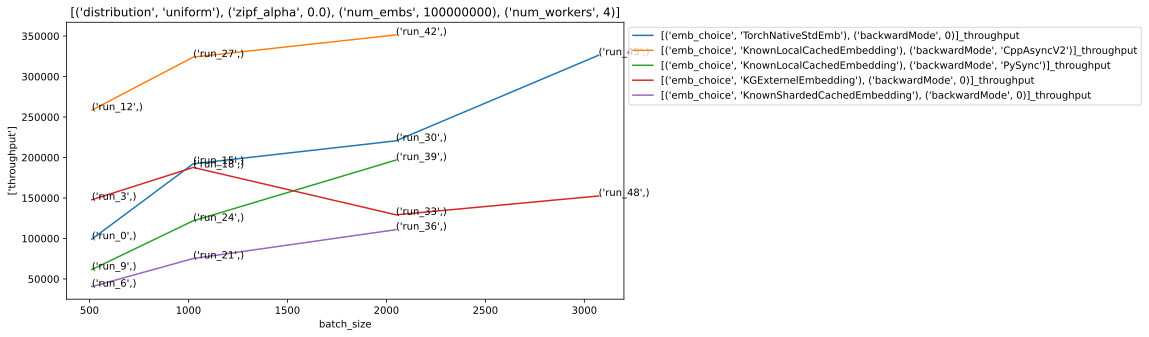

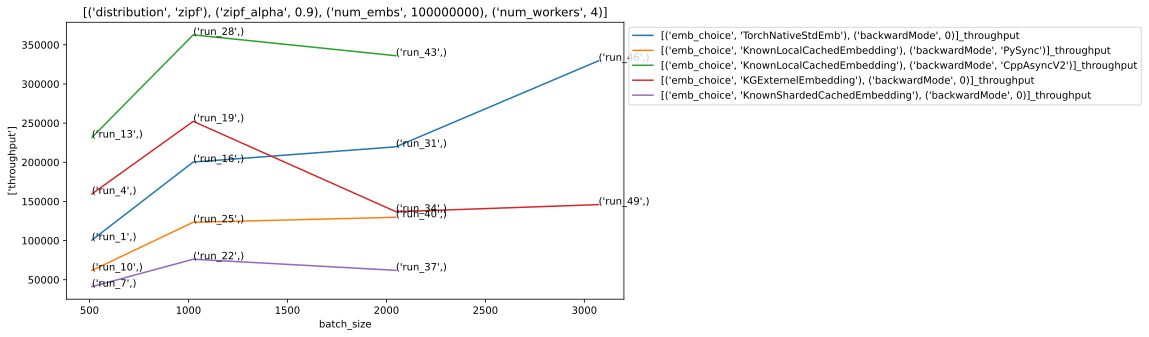

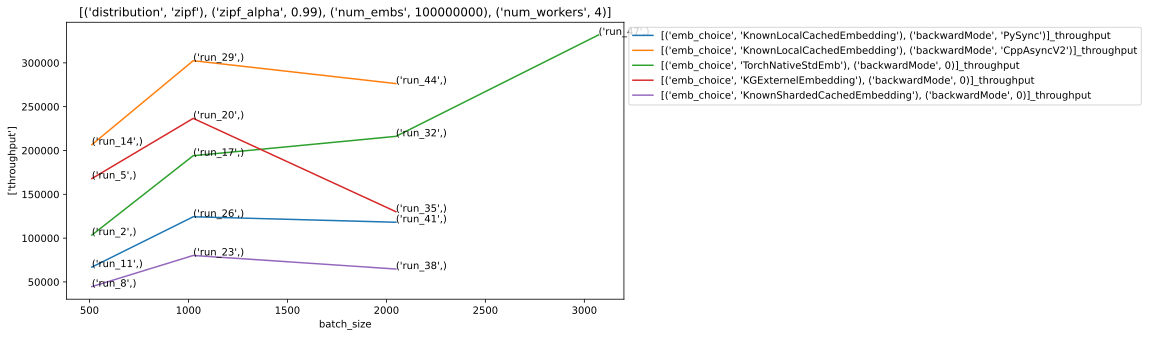

In [20]:
df = parse_logs_to_df("../benchmark/log/0117-exp1-macro-perf-emb-A30")
# # NOTE(1): 1000 是统计周期的step个数！！！！！！！
df['throughput'] = df['num_workers'] * df['batch_size'] * (1 / df['per_step_mean'])
df = df.fillna(0)

# show_df = df[df['num_embs'] == int(100*1e6)]
show_df = df
DecoupleAnalysis(show_df, 
for_variables = ['distribution', 'zipf_alpha', 'num_embs', 'num_workers'], 
line_variables = ['emb_choice', 'backwardMode'], 
x_variable = 'batch_size', 
y_variable = ['throughput',],
sort_variable = 'batch_size',
mark_variable="run_id",
legend_loc='out'
)

# Moti

In [22]:
df_3090 = parse_logs_to_df("../benchmark/log/0116-exp2-motiv-emb-3090")
df_3090['gpu_type'] = "3090"

df_a30 = parse_logs_to_df("../benchmark/log/0116-exp2-motiv-emb-A30")
df_a30['gpu_type'] = "a30"

df = pd.concat([df_a30, df_3090], axis=0, ignore_index=True)
# df = pd.concat([df_a30, ], axis=0, ignore_index=True)
display(df.columns)

df['throughput'] = df['num_workers'] * df['batch_size'] * (1e6 / df['[D] OneStep_Mean'])
df = df.fillna(0)

# show_df = df[df['emb_choice'] == 'KnownShardedCachedEmbedding']
show_df = df

# DecoupleAnalysis(show_df, 
# for_variables = ['distribution', 'zipf_alpha', 'num_embs', 'num_workers', "cache_ratio"], 
# line_variables = ['emb_choice', 'backwardMode', 'gpu_type'], 
# x_variable = 'batch_size', 
# y_variable = ['throughput',],
# sort_variable = 'batch_size',
# mark_variable="run_id",
# legend_loc='in'
# )





100%|██████████| 120/120 [00:00<00:00, 249.99it/s]


Index(['time_mean', 'time_jicha', 'per_step_mean', 'per_step_jicha',
       '[D] GenInput:CircleBuffer_Mean', '[D] GenInput:CircleBuffer_P99',
       '[D] GenInput_Mean', '[D] GenInput_P99', '[D] Forward_Mean',
       '[D] Forward_P99', '[D] Backward_Mean', '[D] Backward_P99',
       '[D] Optimize_Mean', '[D] Optimize_P99', '[D] OneStep_Mean',
       '[D] OneStep_P99', '[D] E2E-100_Mean', '[D] E2E-100_P99', 'run_id',
       'num_workers', 'num_embs', 'batch_size', 'run_steps', 'log_interval',
       'cache_ratio', 'emb_choice', 'distribution', 'zipf_alpha',
       '[D] BarrierTimeBeforeRank0_Mean', '[D] BarrierTimeBeforeRank0_P99',
       '[D] BlockToStepN_Mean', '[D] BlockToStepN_P99', 'backwardMode',
       '[D] ProcessBack:Shuffle_Mean', '[D] ProcessBack:Shuffle_P99',
       '[D] ProcessBack:UpdateCache_Mean', '[D] ProcessBack:UpdateCache_P99',
       '[D] ProcessBack:UpsertPq_Mean', '[D] ProcessBack:UpsertPq_P99',
       '[D] ProcessOneStep_Mean', '[D] ProcessOneStep_P99',
       '

In [23]:

selected_df = df.query('distribution == "zipf" and zipf_alpha == 0.9 and num_embs == 100000000 and num_workers == 4 and cache_ratio == 0.1')


selected_df = selected_df[selected_df['emb_choice'] == 'KnownShardedCachedEmbedding']

a2a_primitives = ['forward: a2a keys', 'forward: a2a values', 'back: aggr dram keys', 'back: a2a grad']
cache_primitives = ['forward: search cache',]
software_primitives= ['forward: join']
other = ['bucket keys', 'back: set dram grad', 'back: grad sum & grad cache']
opt = ['Optimize']

a2a_primitives = [f'[D] {each}_Mean' for each in a2a_primitives]
cache_primitives = [f'[D] {each}_Mean' for each in cache_primitives]
software_primitives = [f'[D] {each}_Mean' for each in software_primitives]
other = [f'[D] {each}_Mean' for each in other]
opt = [f'[D] {each}_Mean' for each in opt]


selected_df['a2a'] = selected_df[a2a_primitives].sum(axis=1)
selected_df['cache'] = selected_df[cache_primitives].sum(axis=1)
selected_df['other'] = selected_df[other].sum(axis=1)
selected_df['opt'] = selected_df[opt]
selected_df['software(copy)'] = selected_df[software_primitives].sum(axis=1)


# selected_df = selected_df[['run_id', 'batch_size', 'gpu_type', 'throughput', *a2a_primitives, *cache_primitives, *other, *opt]]
selected_df = selected_df[['run_id', 'batch_size', 'gpu_type', 'throughput', 'a2a', 'cache', 'other', 'opt', 'software(copy)']]
selected_df = selected_df[selected_df['batch_size'].isin([512, 1024, 2048, 4096])]

In [24]:
display(selected_df.groupby(['batch_size', 'gpu_type']).sum())

selected_df.groupby(['batch_size', 'gpu_type']).sum().to_csv("res/motivation.csv")

run_id     throughput       a2a    cache      other  \
batch_size gpu_type                                                         
512        3090        run_4   46511.627907   20560.0  213.282   3533.932   
           a30       run_124   42389.369541   28392.0  294.623   4517.000   
1024       3090       run_34   53572.596361   35418.0  203.802   4338.000   
           a30       run_122   70601.213458   29674.0  229.577   5225.000   
2048       3090       run_64   42390.466285  141521.0  201.260   6580.000   
           a30       run_123   63909.129207   98038.0  148.166   6304.000   
4096       3090       run_94   75964.039484  138335.0  214.092  16781.000   
           a30       run_121  113784.099117   96928.0  146.764  12366.000   

                         opt  software(copy)  
batch_size gpu_type                           
512        3090       4202.0          1619.0  
           a30        6327.0          2107.0  
1024       3090      13314.0         17170.0  
           a30        6880.0         10273.0  
2048       3090      15116.0         29423.0  
           a30        5797.0         13519.0  
4096       3090      19569.0         32637.0  
           a30       10568.0         15637.0

/tmp/ipykernel_47728/4140474576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.drop(['run_id', 'throughput', 'gpu_type'], axis=1, inplace=True)
/tmp/ipykernel_47728/4140474576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.drop(['run_id', 'throughput', 'gpu_type'], axis=1, inplace=True)


<Axes: title={'center': 'multiple stacked bar plot'}, xlabel='batch_size'>

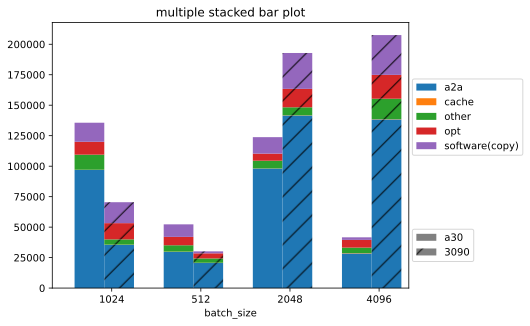

In [26]:
show = []

for each in ['a30', '3090']:
    temp= selected_df[selected_df['gpu_type']== each]
    temp.drop(['run_id', 'throughput', 'gpu_type'], axis=1, inplace=True)
    temp.set_index('batch_size', inplace=True)
    show.append(temp)

plot_clustered_stacked(show,["a30", "3090",])


得出结论：
- 慢1是a2a通信原语慢
- 2是CPU处gather额外拷贝，外加cudaMemcpy带宽低导致的慢

# MacroBenchmark

In [44]:
df_3090 = parse_logs_to_df("../benchmark/log/0116-exp2-motiv-emb-3090")
df_3090['gpu_type'] = "3090"
df = pd.concat([df_3090], axis=0, ignore_index=True)
# display(df.columns)
df['throughput'] = df['num_workers'] * df['batch_size'] * (1e6 / df['[D] OneStep_Mean'])
df = df.fillna(0)
df['throughput'] = df['throughput'].apply(int)

100%|██████████| 603/603 [00:03<00:00, 167.66it/s]


In [54]:
columns = ['distribution', 'num_workers', 'zipf_alpha', 'cache_ratio', 'batch_size', 'throughput', 'emb_choice', 'backwardMode']
show_df = df[columns]
# show_df = df[df['emb_choice'].isin(['KnownLocalCachedEmbedding', 'KnownShardedCachedEmbedding'])]
grouped_df = show_df.groupby(['num_workers', 'distribution', 'zipf_alpha', 'cache_ratio', 'batch_size',  'emb_choice', 'backwardMode']).mean()

display(grouped_df)

grouped_df.to_csv('res/micro_bench/whole.csv')

throughput
num_workers distribution zipf_alpha cache_ratio batch_size emb_choice                  backwardMode            
4           uniform      0.00       0.01        512        KGExternelEmbedding         0               120925.0
                                                           KnownLocalCachedEmbedding   CppAsyncV2      214540.0
                                                                                       PySync           49757.0
                                                           KnownShardedCachedEmbedding 0                25691.0
                                                           TorchNativeStdEmb           0                42681.0
...                                                                                                         ...
8           zipf         0.99       0.10        8192       KnownLocalCachedEmbedding   CppAsyncV2      147094.0
                                                                                       PySync          147645.0
                                                           KnownShardedCachedEmbedding 0               101570.0
                                                           TorchNativeStdEmb           0               363646.0
                                    0.20        512        KGExternelEmbedding         0               300381.0

[603 rows x 1 columns]

In [50]:
def ConvertDf2Csv(df, for_columns, 
                  x_variable,
                  y_variable,
                  dir_path):
    if type(for_variables) is not list:
        for_variables = [for_variables]
    if type(line_variables) is not list:
        line_variables = [line_variables]

    if type(y_variable) is not list:
        y_variable = [y_variable]

    if type(x_variable) is not str:
        raise Exception("current only support one x variable")
    
    for each_graph_specified in itertools.product(*[df[_].unique() for _ in for_variables]):
        kv_pair = list(zip(for_variables, each_graph_specified))
        graph_query_string = QueryStr(kv_pair)
        graph_query_string = TidyQueryStr(graph_query_string)

        sub_df = df.query(graph_query_string)
    
    df.to_csv(filename)

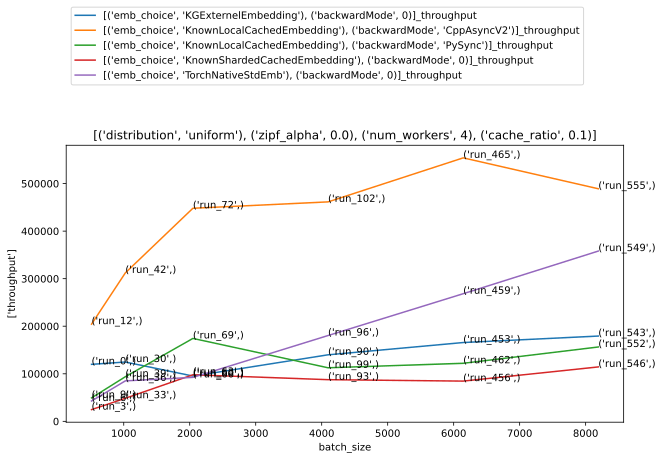

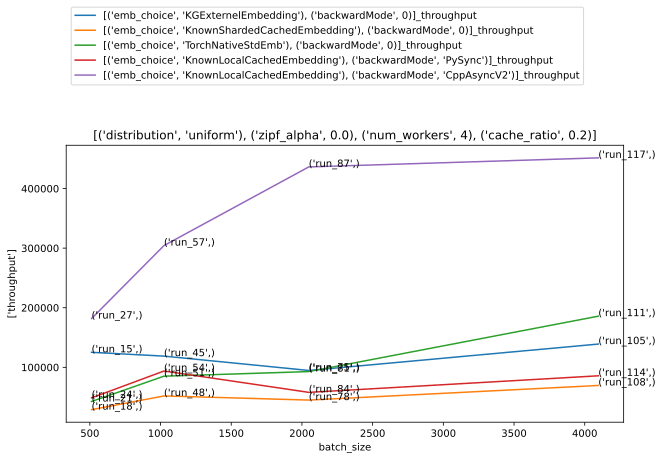

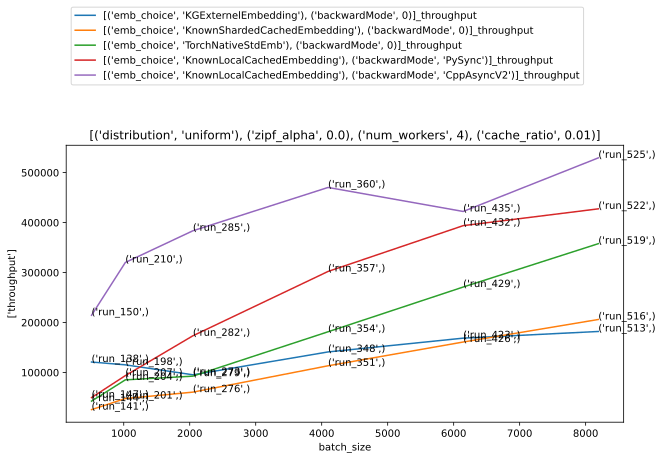

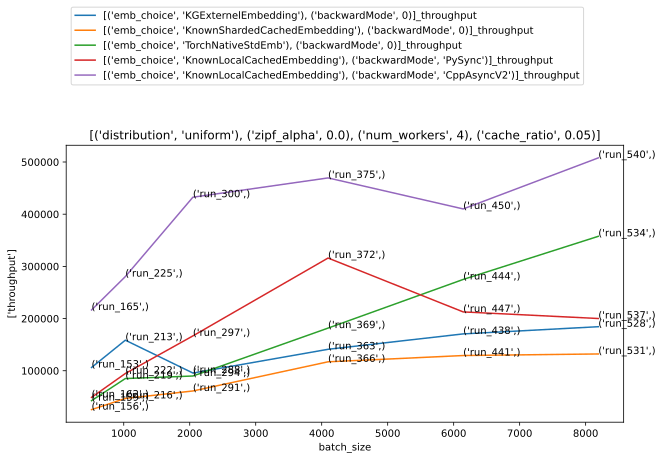

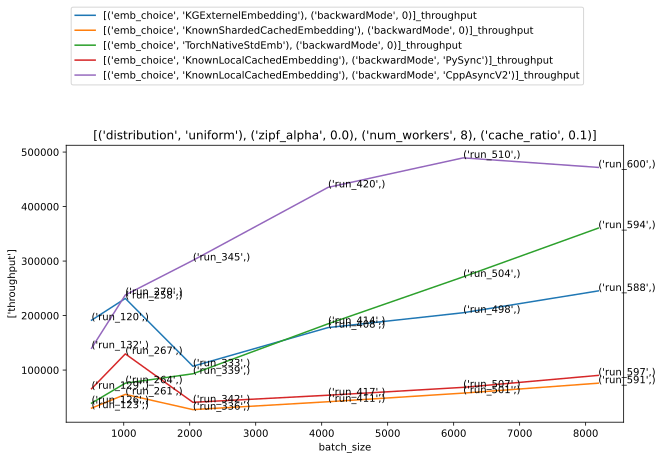

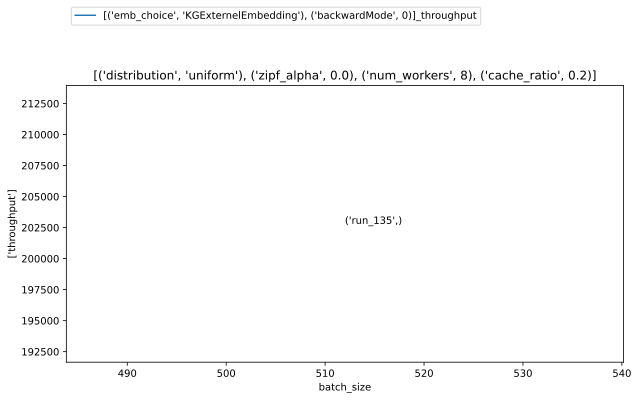

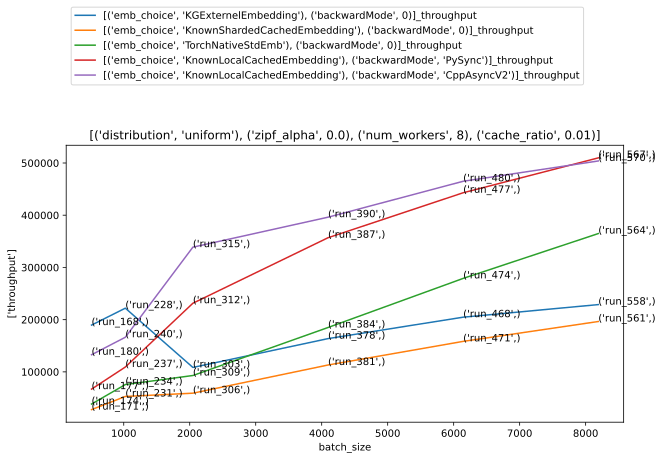

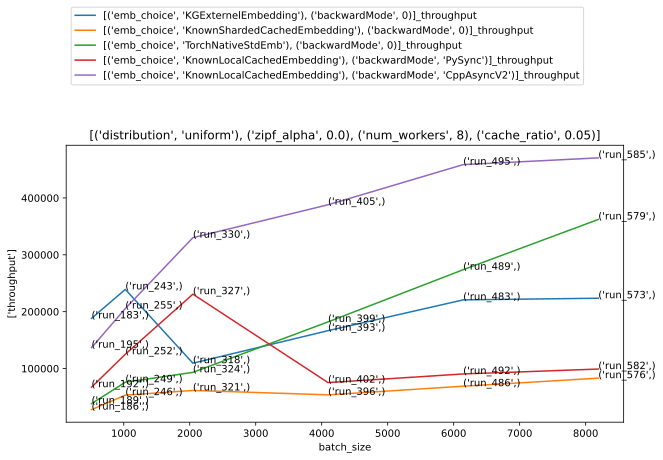

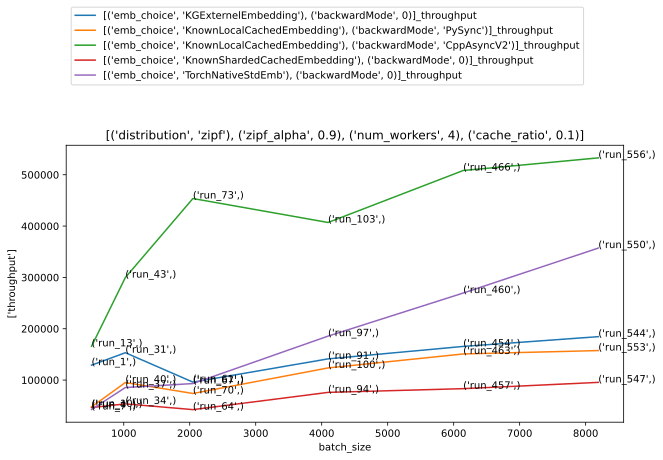

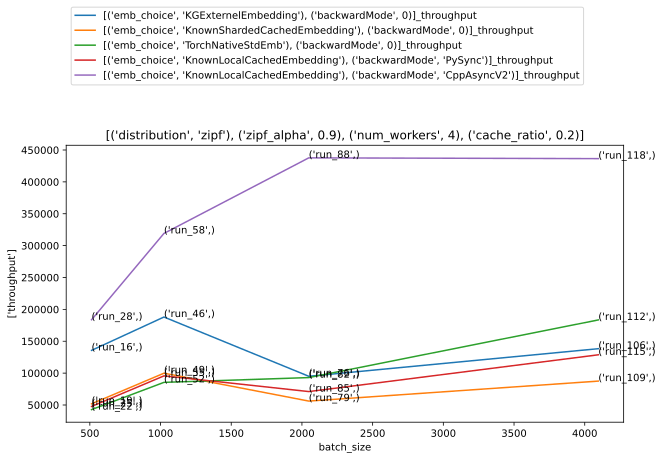

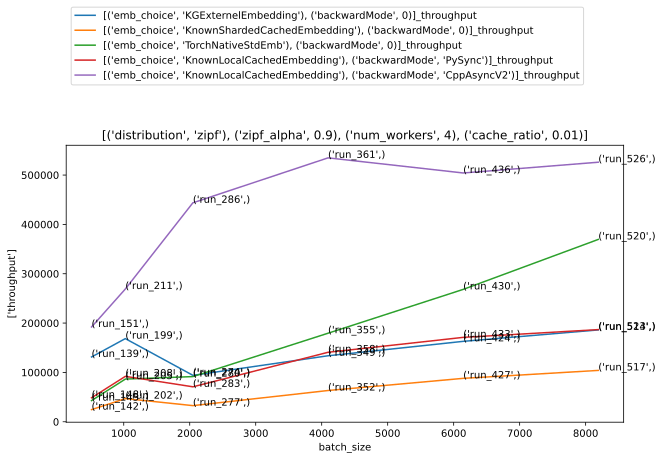

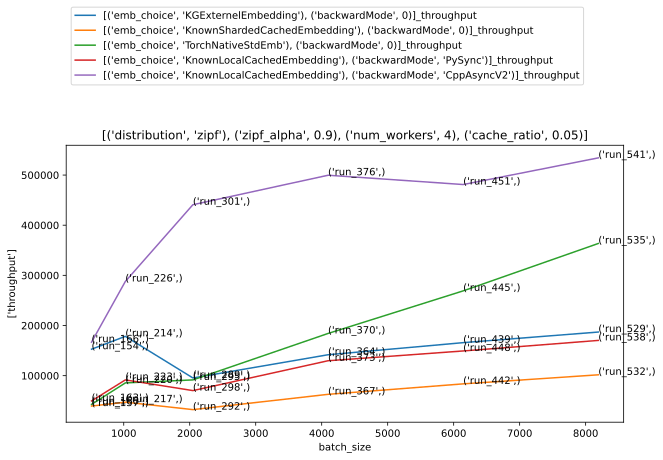

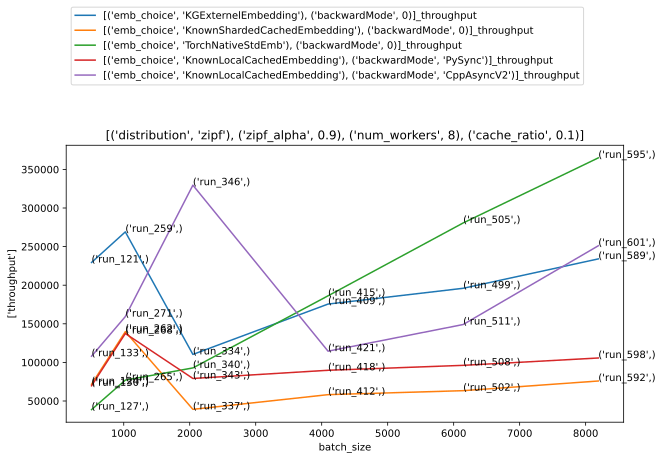

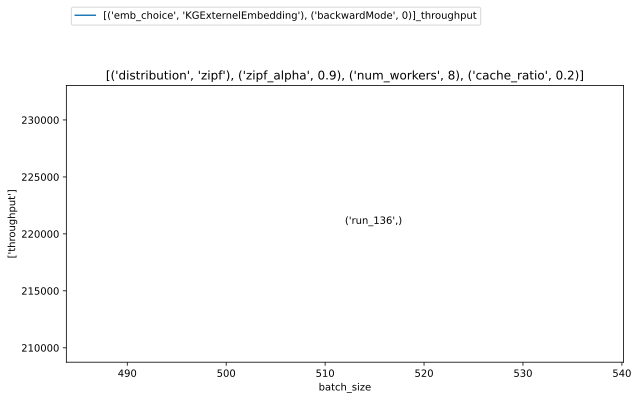

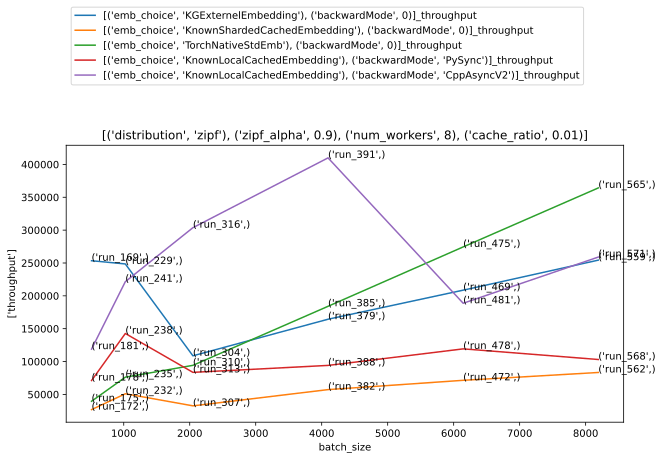

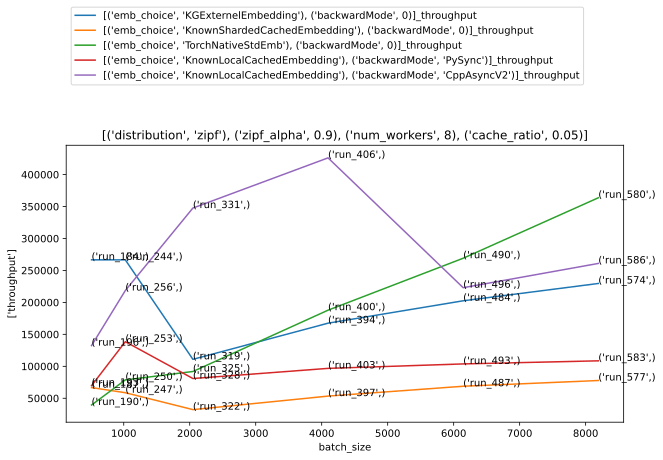

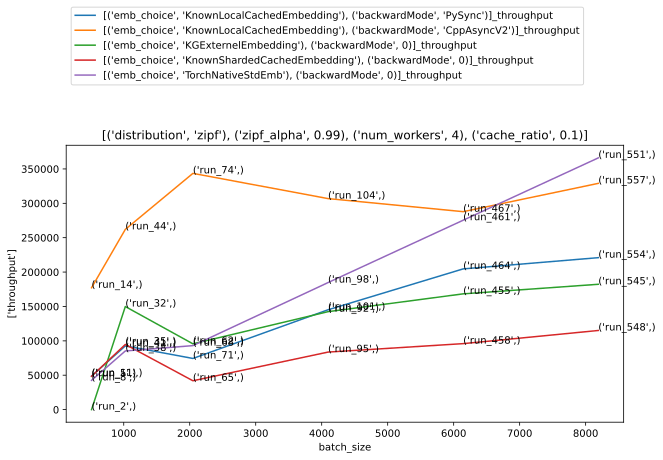

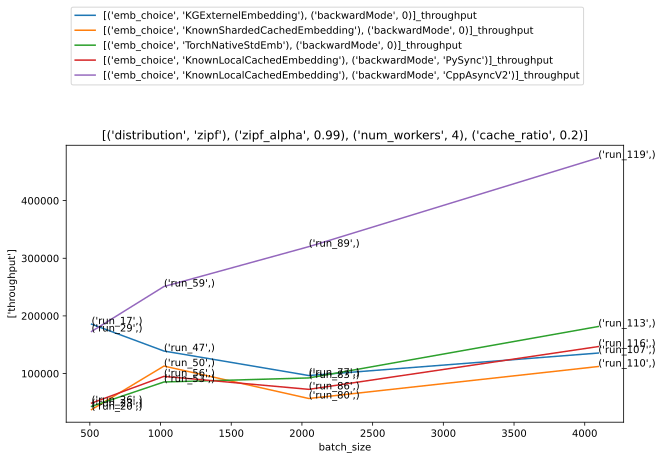

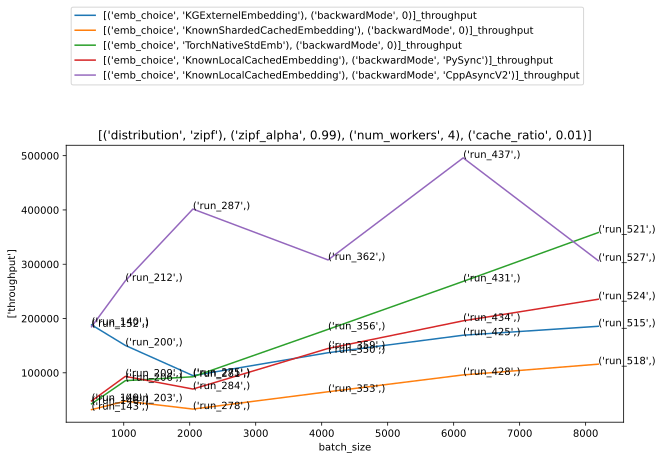

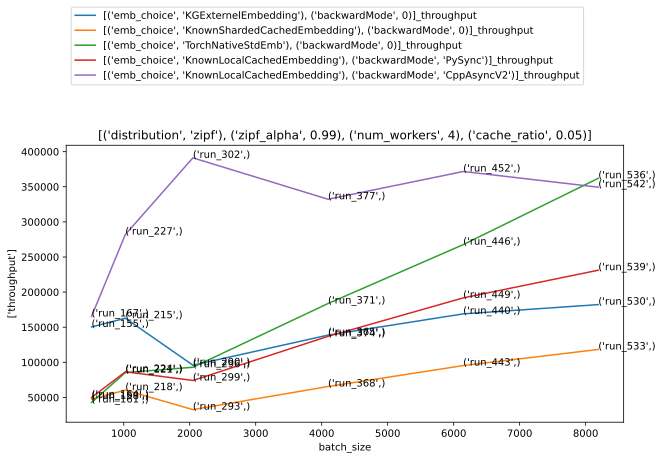

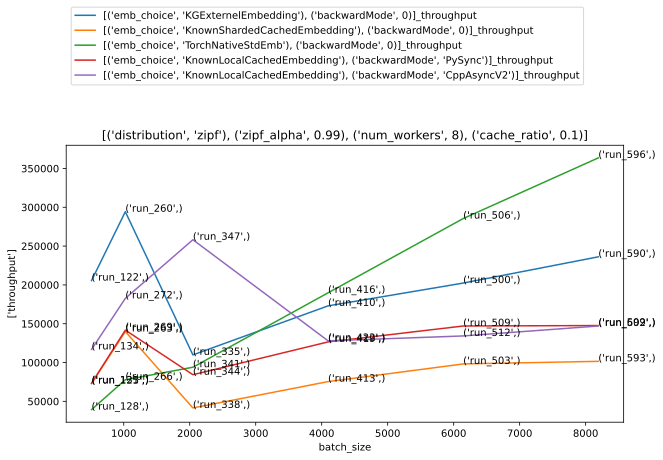

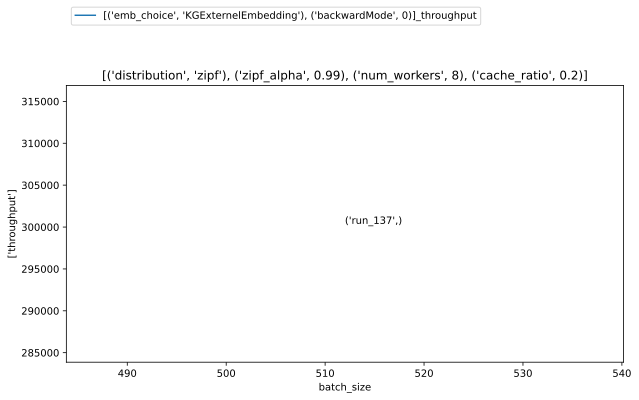

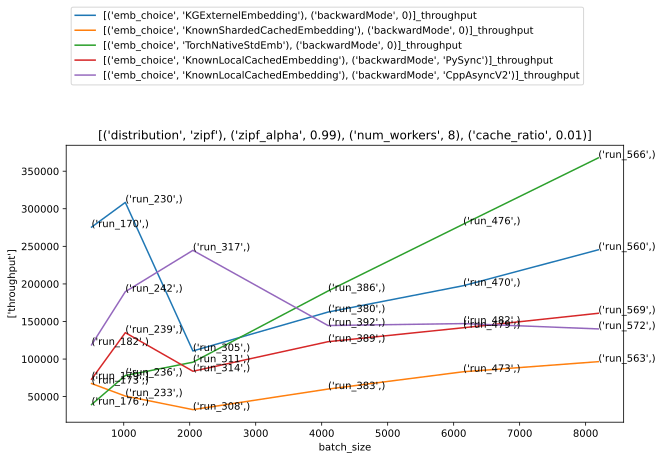

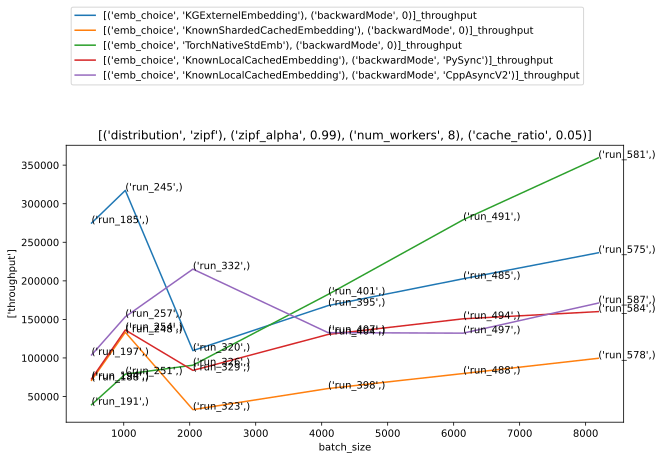

In [52]:
# DecoupleAnalysis(df, 
# for_variables = ['distribution', 'zipf_alpha', 'num_workers', "cache_ratio"], 
# line_variables = ['emb_choice', 'backwardMode',], 
# x_variable = 'batch_size', 
# y_variable = ['throughput',],
# sort_variable = 'batch_size',
# mark_variable="run_id",
# legend_loc='in'
# )

In [46]:
# E2E 




# Graph

In [ ]:
# df_3090 = parse_logs_to_df("../benchmark/log/0117-exp0-KG-3090")
# df_3090['gpu_type'] = "3090"

df_a30 = parse_logs_to_df("../benchmark/log/0117-exp0-KG-A30")
df_a30['gpu_type'] = "a30"

# df = pd.concat([df_a30, df_3090], axis=0, ignore_index=True)
df = pd.concat([df_a30, ], axis=0, ignore_index=True)
display(df.columns)

df['throughput'] = df['nr_gpus'] * df['batch_size'] * (1e6 / df['[D] OneStep_Mean'])
df = df.fillna(0)

# show_df = df[df['emb_choice'] == 'KnownShardedCachedEmbedding']
show_df = df

display(show_df)

# DecoupleAnalysis(show_df, 
# for_variables = ['dataset', 'model_name', 'nr_gpus', "cache_ratio"], 
# line_variables = ['cached_emb_type', 'backwardMode', ], 
# x_variable = 'batch_size', 
# y_variable = ['throughput',],
# sort_variable = 'batch_size',
# mark_variable="run_id",
# legend_loc='in'
# )




100%|██████████| 21/21 [00:00<00:00, 66.95it/s]


Index(['total_mean', 'total_jicha', 'sample_mean', 'sample_jicha',
       'forward_mean', 'forward_jicha', 'backward_mean', 'backward_jicha',
       'update_mean', 'update_jicha', '[D] GenInput_Mean', '[D] GenInput_P99',
       '[D] Forward_Mean', '[D] Forward_P99', '[D] Backward_Mean',
       '[D] Backward_P99', '[D] Optimize_Mean', '[D] Optimize_P99',
       '[D] BarrierTimeBeforeRank0_Mean', '[D] BarrierTimeBeforeRank0_P99',
       '[D] AfterBackward_Mean', '[D] AfterBackward_P99',
       '[D] BlockToStepN_Mean', '[D] BlockToStepN_P99', '[D] OneStep_Mean',
       '[D] OneStep_P99', '[D] ProcessBack:Shuffle_Mean',
       '[D] ProcessBack:Shuffle_P99', '[D] ProcessBack:UpdateCache_Mean',
       '[D] ProcessBack:UpdateCache_P99', '[D] ProcessBack:UpsertPq_Mean',
       '[D] ProcessBack:UpsertPq_P99', '[D] ProcessOneStep_Mean',
       '[D] ProcessOneStep_P99', 'run_id', 'model_name', 'nr_gpus',
       'batch_size', 'log_interval', 'neg_sample_size', 'regularization_coef',
       'gamma'

,total_mean,total_jicha,sample_mean,sample_jicha,forward_mean,forward_jicha,backward_mean,backward_jicha,update_mean,update_jicha,...,[D] back: aggr dram keys_Mean,[D] back: aggr dram keys_P99,[D] back: set dram grad_Mean,[D] back: set dram grad_P99,[D] back: a2a grad_Mean,[D] back: a2a grad_P99,[D] back: grad sum & grad cache_Mean,[D] back: grad sum & grad cache_P99,gpu_type,throughput
0,13.620,0.0,0.558667,0.177,0.564000,0.078,2.510000,3.132,0.331333,0.103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,144709.074465
1,9.339,0.0,0.520000,0.392,1.006667,0.213,0.221000,0.006,1.096333,0.369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,210614.071653
2,3.611,0.0,0.401667,0.092,0.971000,0.036,0.355667,0.013,0.966000,0.128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,627450.980392
3,21.010,0.0,0.449333,0.354,1.210000,0.390,13.665667,3.061,0.264000,0.134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,94244.692600
4,301.578,0.0,0.337333,0.052,1.007667,0.052,275.560000,42.862,0.282333,0.045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,11671.732523
5,19.638,0.0,0.612333,0.349,4.762000,0.245,11.407333,2.274,0.800333,1.046,...,50354.0,58638.0,2136.0,5461.0,5741.0,6604.0,3468.0,5138.0,a30,99993.229625
6,16.239,0.0,0.698000,0.153,1.575000,0.270,11.554000,0.658,0.442667,0.126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,124495.856622
7,274.684,0.0,0.331000,0.052,1.003667,0.129,261.475333,10.056,0.273333,0.056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,12451.361868
8,15.012,0.0,0.643000,0.103,4.403333,0.149,7.863000,0.044,0.907000,1.457,...,25597.0,33914.0,2338.0,6083.0,5843.0,6702.0,3778.0,7094.0,a30,130063.677009
9,16.171,0.0,0.735333,0.073,1.396000,0.261,11.591333,0.519,0.416667,0.065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,127018.569850


In [ ]:
performance_column = ['throughput', '[D] Forward_Mean', '[D] Backward_Mean', '[D] Optimize_Mean', '[D] AfterBackward_Mean']
show_df = show_df[['run_id', 'dataset', 'model_name', 'nr_gpus', 'batch_size', 'backwardMode', 'cached_emb_type', *performance_column]]

show_df.groupby(['dataset', 'model_name', 'nr_gpus', 'batch_size', 'cached_emb_type','backwardMode', ]).max()


run_id  \
dataset model_name nr_gpus batch_size cached_emb_type             backwardMode           
FB15k   ComplEx    4       4800       KGExternelEmbedding         PySync        run_20   
                                      KnownLocalCachedEmbedding   CppAsyncV2     run_7   
                                      None                        CppSync        run_8   
        DistMult   4       4800       KGExternelEmbedding         PySync        run_17   
                                      KnownLocalCachedEmbedding   CppAsyncV2     run_5   
                                      KnownShardedCachedEmbedding PySync        run_19   
                                      None                        CppSync        run_6   
                                      TorchNativeStdEmb           PySync        run_18   
        SimplE     4       4800       KnownLocalCachedEmbedding   CppAsyncV2     run_9   
                                      None                        CppSync       run_10   
        TransE     4       4800       KGExternelEmbedding         PySync        run_14   
                                      KnownLocalCachedEmbedding   CppAsyncV2     run_2   
                                      KnownShardedCachedEmbedding PySync        run_16   
                                      None                        CppSync        run_3   
                                      TorchNativeStdEmb           PySync        run_15   
        TransE_l1  4       4800       KGExternelEmbedding         PySync        run_11   
                                      KnownLocalCachedEmbedding   CppAsyncV2     run_0   
                                      KnownShardedCachedEmbedding PySync        run_13   
                                      None                        CppSync        run_1   
                                      TorchNativeStdEmb           PySync        run_12   
        TransR     4       4800       KnownLocalCachedEmbedding   CppAsyncV2     run_4   

                                                                                   throughput  \
dataset model_name nr_gpus batch_size cached_emb_type             backwardMode                  
FB15k   ComplEx    4       4800       KGExternelEmbedding         PySync        117983.224260   
                                      KnownLocalCachedEmbedding   CppAsyncV2    156672.025068   
                                      None                        CppSync       572894.909590   
        DistMult   4       4800       KGExternelEmbedding         PySync        127018.569850   
                                      KnownLocalCachedEmbedding   CppAsyncV2    175358.480227   
                                      KnownShardedCachedEmbedding PySync        129748.139939   
                                      None                        CppSync       634983.629328   
                                      TorchNativeStdEmb           PySync         12075.471698   
        SimplE     4       4800       KnownLocalCachedEmbedding   CppAsyncV2    130619.353434   
                                      None                        CppSync       627450.980392   
        TransE     4       4800       KGExternelEmbedding         PySync        124495.856622   
                                      KnownLocalCachedEmbedding   CppAsyncV2    144674.181687   
                                      KnownShardedCachedEmbedding PySync        130063.677009   
                                      None                        CppSync       674891.911842   
                                      TorchNativeStdEmb           PySync         12451.361868   
        TransE_l1  4       4800       KGExternelEmbedding         PySync         94244.692600   
                                      KnownLocalCachedEmbedding   CppAsyncV2    144709.074465   
                                      KnownShardedCachedEmbedding PySync         99993.229625   
                                      None                        Cpp

In [ ]:
# df_3090 = parse_logs_to_df("../benchmark/log/0117-exp0-KG-3090")
# df_3090['gpu_type'] = "3090"

df_a30 = parse_logs_to_df("../benchmark/log/0117-exp0-KG-A30")
df_a30['gpu_type'] = "a30"

# df = pd.concat([df_a30, df_3090], axis=0, ignore_index=True)
df = pd.concat([df_a30, ], axis=0, ignore_index=True)
display(df.columns)

df['throughput'] = df['nr_gpus'] * df['batch_size'] * (1e6 / df['[D] OneStep_Mean'])
df = df.fillna(0)

# show_df = df[df['emb_choice'] == 'KnownShardedCachedEmbedding']
show_df = df

display(show_df)

# DecoupleAnalysis(show_df, 
# for_variables = ['dataset', 'model_name', 'nr_gpus', "cache_ratio"], 
# line_variables = ['cached_emb_type', 'backwardMode', ], 
# x_variable = 'batch_size', 
# y_variable = ['throughput',],
# sort_variable = 'batch_size',
# mark_variable="run_id",
# legend_loc='in'
# )


100%|██████████| 21/21 [00:00<00:00, 66.56it/s]


Index(['total_mean', 'total_jicha', 'sample_mean', 'sample_jicha',
       'forward_mean', 'forward_jicha', 'backward_mean', 'backward_jicha',
       'update_mean', 'update_jicha', '[D] GenInput_Mean', '[D] GenInput_P99',
       '[D] Forward_Mean', '[D] Forward_P99', '[D] Backward_Mean',
       '[D] Backward_P99', '[D] Optimize_Mean', '[D] Optimize_P99',
       '[D] BarrierTimeBeforeRank0_Mean', '[D] BarrierTimeBeforeRank0_P99',
       '[D] AfterBackward_Mean', '[D] AfterBackward_P99',
       '[D] BlockToStepN_Mean', '[D] BlockToStepN_P99', '[D] OneStep_Mean',
       '[D] OneStep_P99', '[D] ProcessBack:Shuffle_Mean',
       '[D] ProcessBack:Shuffle_P99', '[D] ProcessBack:UpdateCache_Mean',
       '[D] ProcessBack:UpdateCache_P99', '[D] ProcessBack:UpsertPq_Mean',
       '[D] ProcessBack:UpsertPq_P99', '[D] ProcessOneStep_Mean',
       '[D] ProcessOneStep_P99', 'run_id', 'model_name', 'nr_gpus',
       'batch_size', 'log_interval', 'neg_sample_size', 'regularization_coef',
       'gamma'

,total_mean,total_jicha,sample_mean,sample_jicha,forward_mean,forward_jicha,backward_mean,backward_jicha,update_mean,update_jicha,...,[D] back: aggr dram keys_Mean,[D] back: aggr dram keys_P99,[D] back: set dram grad_Mean,[D] back: set dram grad_P99,[D] back: a2a grad_Mean,[D] back: a2a grad_P99,[D] back: grad sum & grad cache_Mean,[D] back: grad sum & grad cache_P99,gpu_type,throughput
0,13.620,0.0,0.558667,0.177,0.564000,0.078,2.510000,3.132,0.331333,0.103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,144709.074465
1,9.339,0.0,0.520000,0.392,1.006667,0.213,0.221000,0.006,1.096333,0.369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,210614.071653
2,3.611,0.0,0.401667,0.092,0.971000,0.036,0.355667,0.013,0.966000,0.128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,627450.980392
3,21.010,0.0,0.449333,0.354,1.210000,0.390,13.665667,3.061,0.264000,0.134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,94244.692600
4,301.578,0.0,0.337333,0.052,1.007667,0.052,275.560000,42.862,0.282333,0.045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,11671.732523
5,19.638,0.0,0.612333,0.349,4.762000,0.245,11.407333,2.274,0.800333,1.046,...,50354.0,58638.0,2136.0,5461.0,5741.0,6604.0,3468.0,5138.0,a30,99993.229625
6,16.239,0.0,0.698000,0.153,1.575000,0.270,11.554000,0.658,0.442667,0.126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,124495.856622
7,274.684,0.0,0.331000,0.052,1.003667,0.129,261.475333,10.056,0.273333,0.056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,12451.361868
8,15.012,0.0,0.643000,0.103,4.403333,0.149,7.863000,0.044,0.907000,1.457,...,25597.0,33914.0,2338.0,6083.0,5843.0,6702.0,3778.0,7094.0,a30,130063.677009
9,16.171,0.0,0.735333,0.073,1.396000,0.261,11.591333,0.519,0.416667,0.065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a30,127018.569850


 ## Graph Scalability

In [58]:
df_3090 = parse_logs_to_df("../benchmark/log/exp3-KG-scale-3090/")
df_3090['gpu_type'] = "3090"
df = df_3090
display(df.columns)

df['throughput'] = df['nr_gpus'] * df['batch_size'] * (1e6 / df['[D] OneStep_Mean'])
df = df.fillna(0)

# show_df = df[df['emb_choice'] == 'KnownShardedCachedEmbedding']

# DecoupleAnalysis(show_df, 
# for_variables = ['dataset', 'model_name', 'nr_gpus', "cache_ratio"], 
# line_variables = ['cached_emb_type', 'backwardMode', ], 
# x_variable = 'batch_size', 
# y_variable = ['throughput',],
# sort_variable = 'batch_size',
# mark_variable="run_id",
# legend_loc='in'
# )


100%|██████████| 120/120 [00:00<00:00, 157.48it/s]


Index(['total_mean', 'total_jicha', 'sample_mean', 'sample_jicha',
       'forward_mean', 'forward_jicha', 'backward_mean', 'backward_jicha',
       'update_mean', 'update_jicha', '[D] GenInput_Mean', '[D] GenInput_P99',
       '[D] Forward_Mean', '[D] Forward_P99', '[D] Backward_Mean',
       '[D] Backward_P99', '[D] Optimize_Mean', '[D] Optimize_P99',
       '[D] BarrierTimeBeforeRank0_Mean', '[D] BarrierTimeBeforeRank0_P99',
       '[D] AfterBackward_Mean', '[D] AfterBackward_P99',
       '[D] BlockToStepN_Mean', '[D] BlockToStepN_P99', '[D] OneStep_Mean',
       '[D] OneStep_P99', '[D] ProcessBack:Shuffle_Mean',
       '[D] ProcessBack:Shuffle_P99', '[D] ProcessBack:UpdateCache_Mean',
       '[D] ProcessBack:UpdateCache_P99', '[D] ProcessBack:UpsertPq_Mean',
       '[D] ProcessBack:UpsertPq_P99', '[D] ProcessOneStep_Mean',
       '[D] ProcessOneStep_P99', 'run_id', 'model_name', 'nr_gpus',
       'log_interval', 'neg_sample_size', 'regularization_coef', 'gamma', 'lr',
       'batch

In [60]:
performance_column = ['throughput', '[D] Forward_Mean', '[D] Backward_Mean', '[D] Optimize_Mean', '[D] AfterBackward_Mean']
show_df = df[['run_id', 'dataset', 'model_name', 'nr_gpus', 'batch_size', 'backwardMode', 'cached_emb_type', *performance_column]]
show_df = show_df.groupby(['dataset', 'model_name', 'nr_gpus', 'batch_size',
                           'cached_emb_type','backwardMode', ], ).max()

display(show_df)


show_df.to_csv("res/kg_scale/result.csv")

run_id  \
dataset  model_name nr_gpus batch_size cached_emb_type             backwardMode            
FB15k    TransE     2       400        KGExternelEmbedding         PySync          run_2   
                                       KnownLocalCachedEmbedding   CppAsyncV2      run_0   
                                       KnownShardedCachedEmbedding PySync          run_4   
                                       None                        CppSync         run_1   
                                       TorchNativeStdEmb           PySync          run_3   
...                                                                                  ...   
Freebase TransE     8       2000       KGExternelEmbedding         PySync        run_122   
                                       KnownLocalCachedEmbedding   CppAsyncV2    run_120   
                                       KnownShardedCachedEmbedding PySync        run_124   
                                       None                        CppSync       run_121   
                                       TorchNativeStdEmb           PySync        run_123   

                                                                                    throughput  \
dataset  model_name nr_gpus batch_size cached_emb_type             backwardMode                  
FB15k    TransE     2       400        KGExternelEmbedding         PySync         19392.058952   
                                       KnownLocalCachedEmbedding   CppAsyncV2     41924.326591   
                                       KnownShardedCachedEmbedding PySync         11244.957339   
                                       None                        CppSync        63943.729518   
                                       TorchNativeStdEmb           PySync          3449.658699   
...                                                                                        ...   
Freebase TransE     8       2000       KGExternelEmbedding         PySync        101241.473570   
                                       KnownLocalCachedEmbedding   CppAsyncV2     80374.141629   
                                       KnownShardedCachedEmbedding PySync         57032.865189   
                                       None                        CppSync       379524.645382   
                                       TorchNativeStdEmb           PySync         11283.497884   

                                                                                 [D] Forward_Mean  \
dataset  model_name nr_gpus batch_size cached_emb_type             backwardMode                     
FB15k    TransE     2       400        KGExternelEmbedding         PySync                  5454.0   
                                       KnownLocalCachedEmbedding   CppAsyncV2              3372.0   
                                       KnownShardedCachedEmbedding PySync                 14002.0   
                                       None                        CppSync                 3860.0   
                                       TorchNativeStdEmb           PySync                  3894.0   
...                                                                                           ...   
Freebase TransE     8       2000       KGExternelEmbedding         PySync                 10398.0   
                                       KnownLocalCachedEmbedding   CppAsyncV2              5449.0   
                                       KnownShardedCachedEmbedding PySync                 47000.0   
                                       None                        CppSync                 9771.0   
                                       TorchNativeStdEmb           PySync                 10025.0   

                                                                                 [D] Backward_Mean  \
dataset  model_name nr_gpus batch_size cached_emb_type             backwardMode                      
FB15k    TransE     2       400        KGExternelEmbedding         PySync                  2

In [ ]:
def NormalizeBy(df, for_variables)